# **Imports**

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, make_scorer, recall_score, roc_auc_score, roc_curve
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA

# **Main Dataset**

In [75]:
# Set the path to the file you'd like to load
file_path = "heart.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/heart-failure-prediction",
  file_path
)

df.head()

C:\Users\fares\AppData\Local\Temp\ipykernel_9632\1036516865.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [77]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# **EDA | Exploraotry Data Analysis**

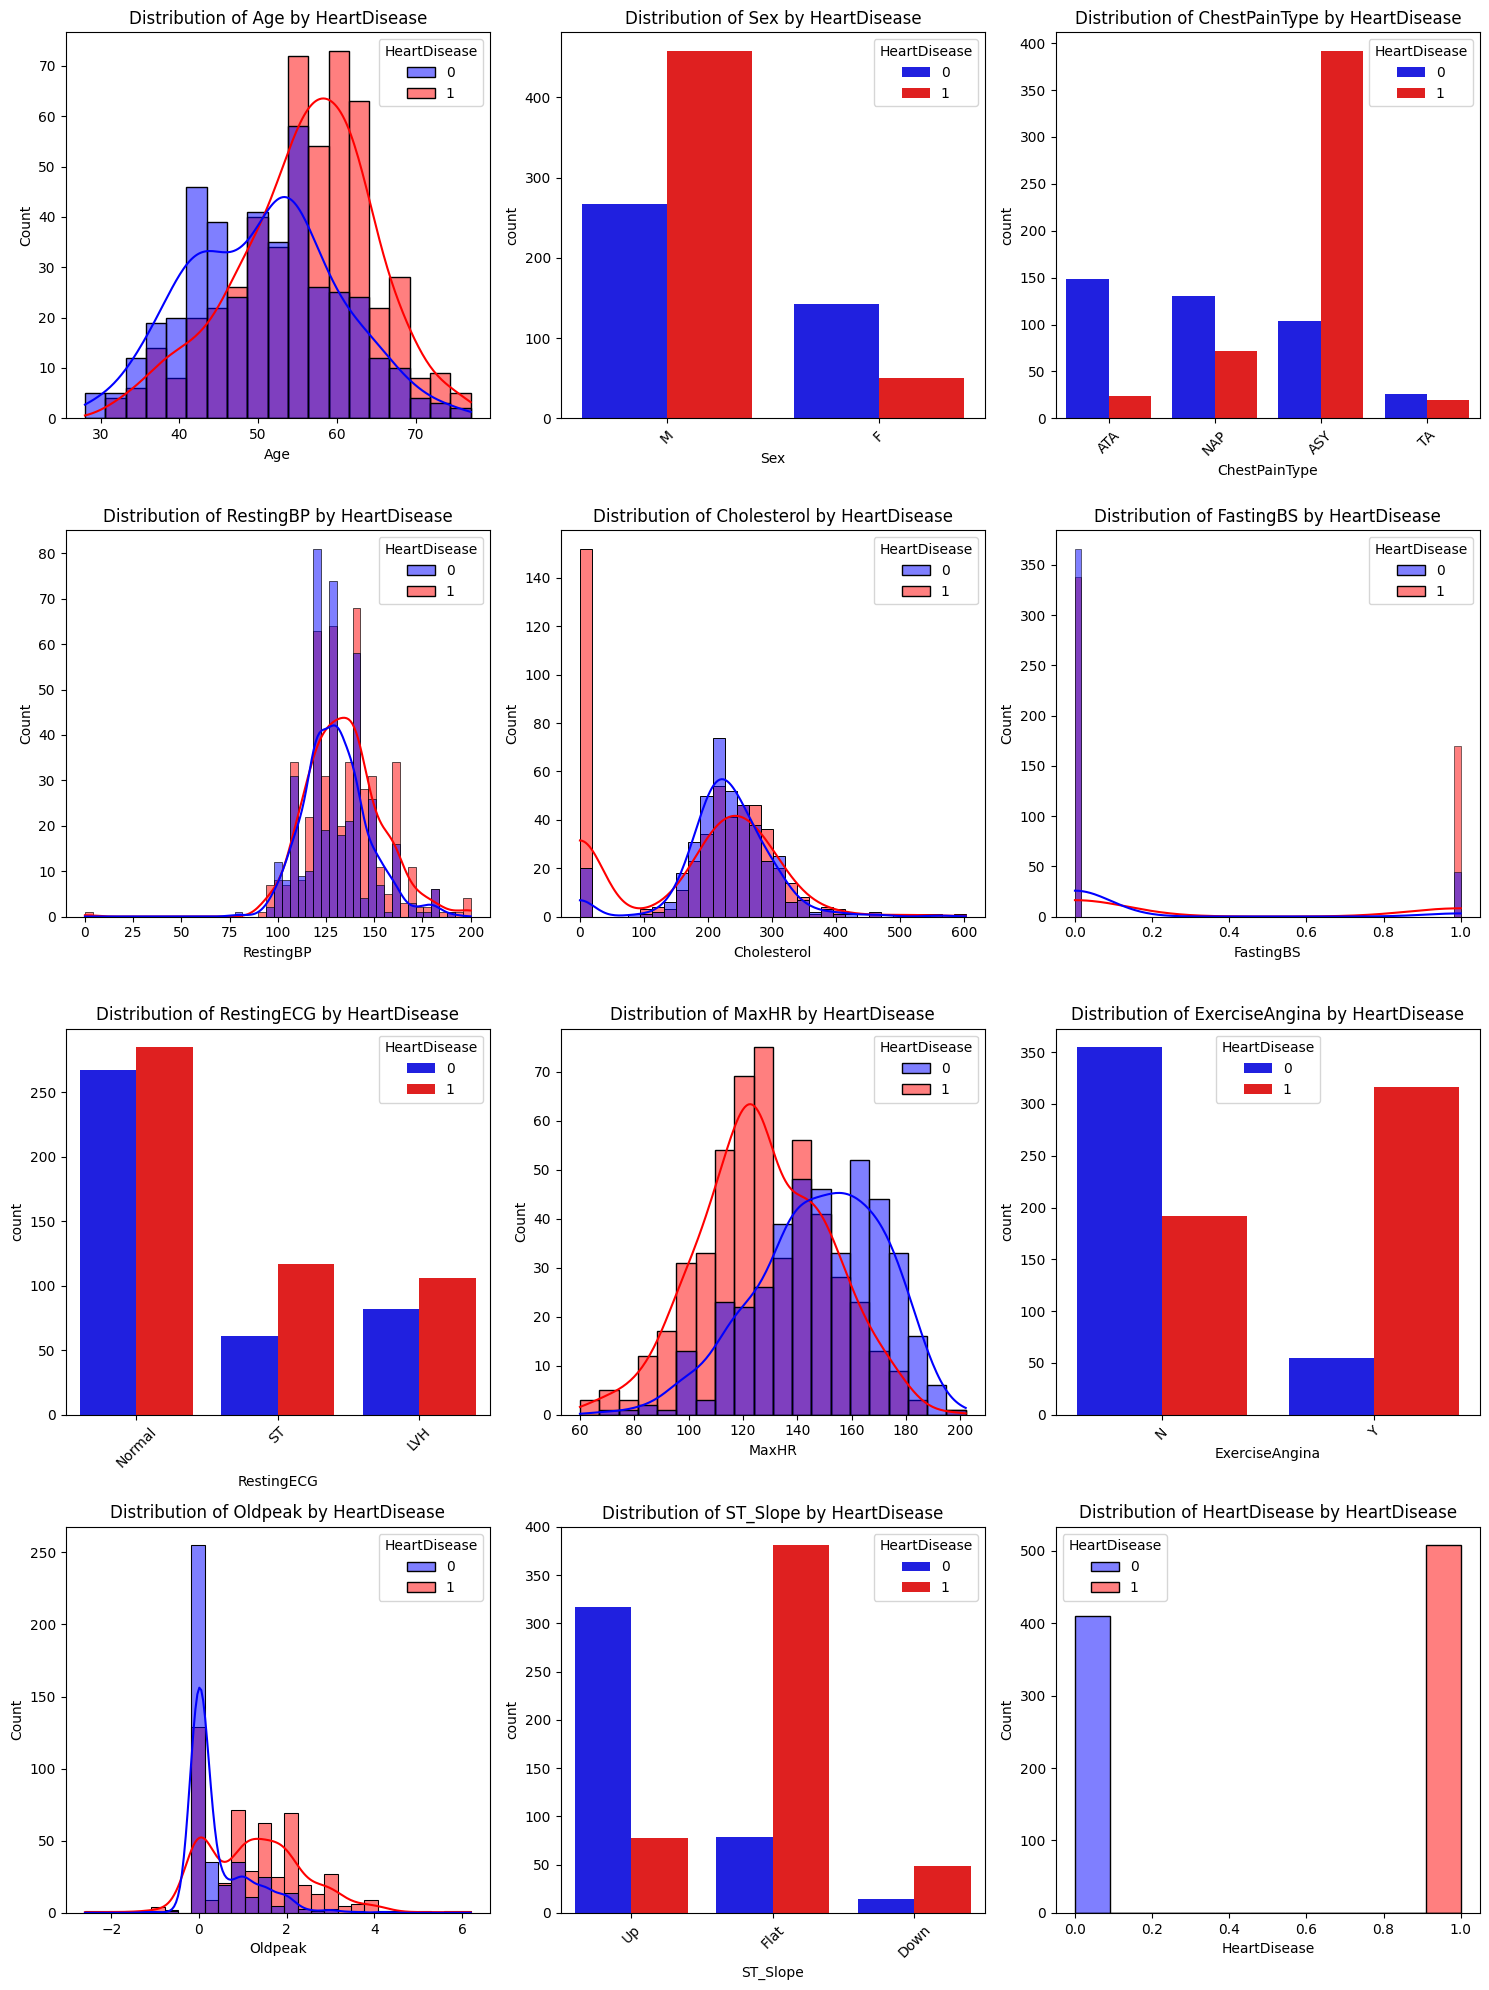

In [ ]:
columns = df.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

palette = {0: 'blue', 1: 'red'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    if df[col].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x=col, kde=True, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
    else:
        sns.countplot(data=df, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
        axes[i].tick_params(axis='x', rotation=45)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

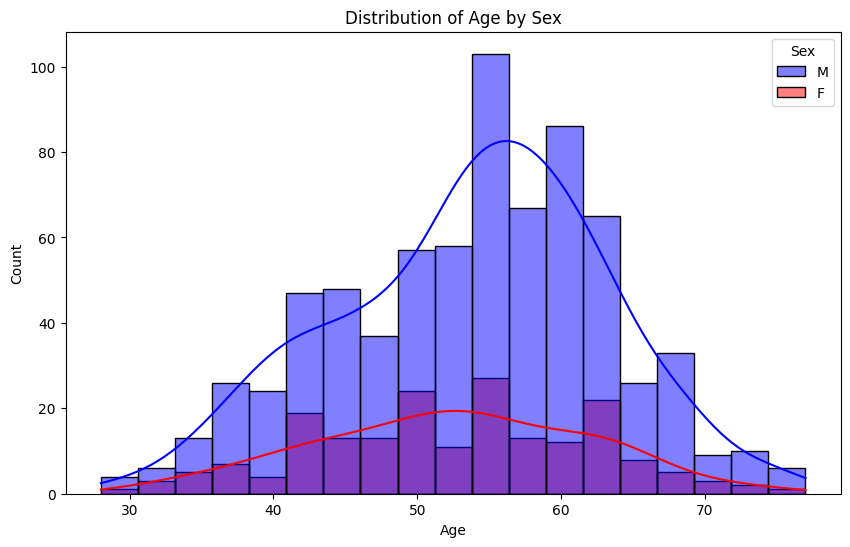

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Sex', kde=True, palette = {'M': 'blue', 'F': 'red'})
plt.title('Distribution of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

C:\Users\fares\AppData\Local\Temp\ipykernel_9632\2829498539.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Heart Disease")


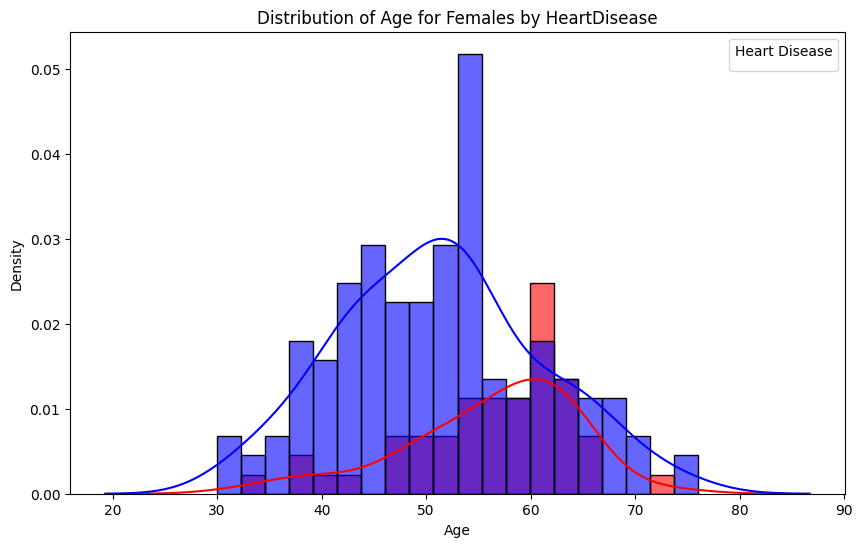

In [89]:
plt.figure(figsize=(10, 6))
female_df = df[df['Sex'] != 'M']
sns.histplot(
    data=female_df,
    x='Age',
    hue='HeartDisease',
    bins=20,
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    stat="density"
)

sns.kdeplot(
    data=female_df,
    x='Age',
    hue='HeartDisease',
    palette={0: 'blue', 1: 'red'}
)

plt.title('Distribution of Age for Females by HeartDisease')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title="Heart Disease")
plt.show()

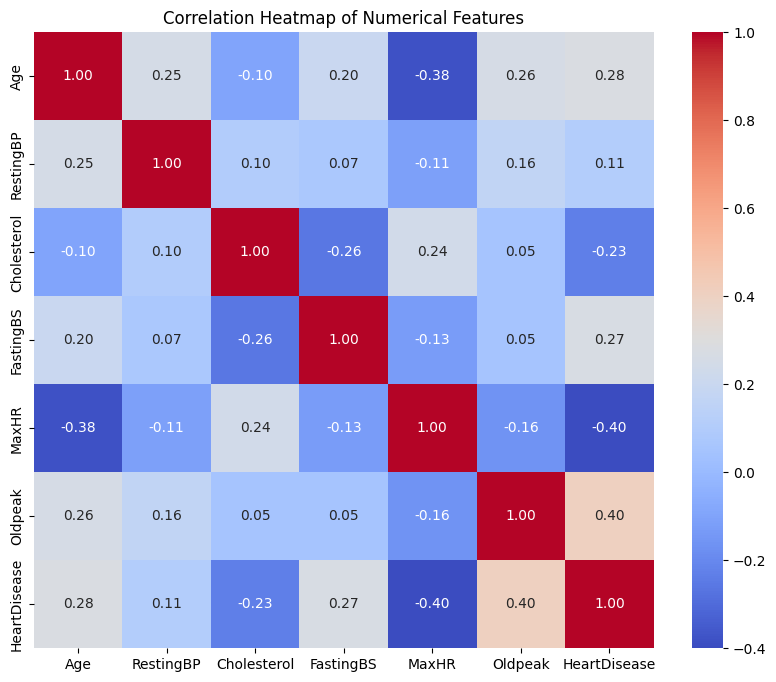

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

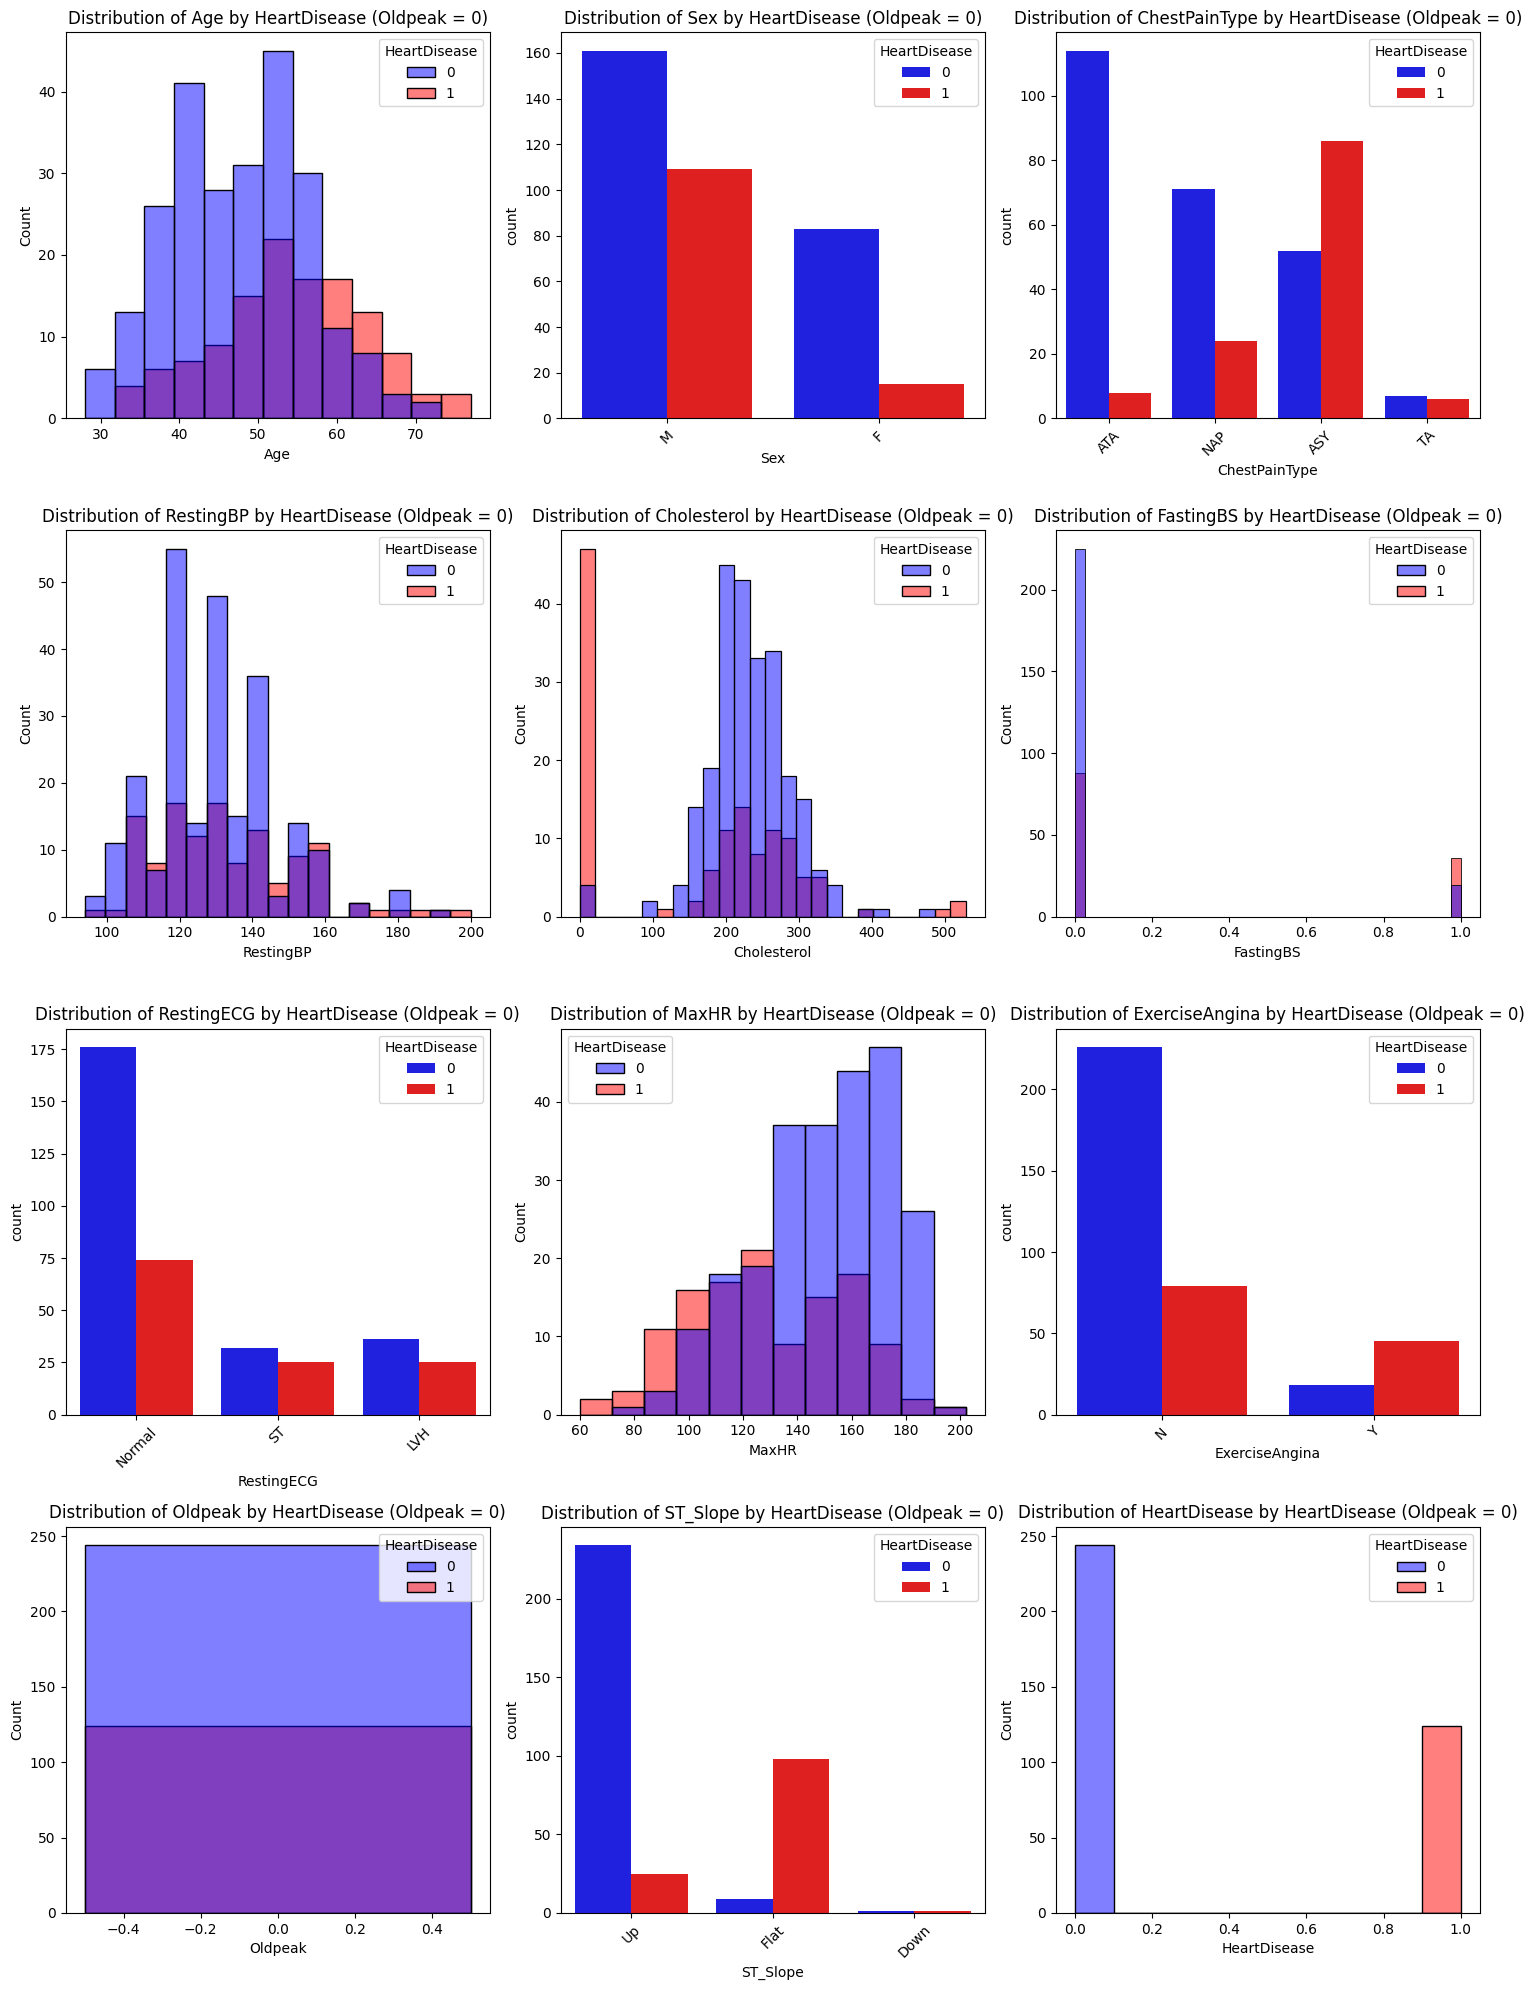

In [ ]:
df_filtered_oldpeak = df[df['Oldpeak'] == 0].copy()

columns = df_filtered_oldpeak.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

palette = {0: 'blue', 1: 'red'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    if df_filtered_oldpeak[col].dtype in ['int64', 'float64']:
        sns.histplot(data=df_filtered_oldpeak, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease (Oldpeak = 0)')
    else:
        sns.countplot(data=df_filtered_oldpeak, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease (Oldpeak = 0)')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

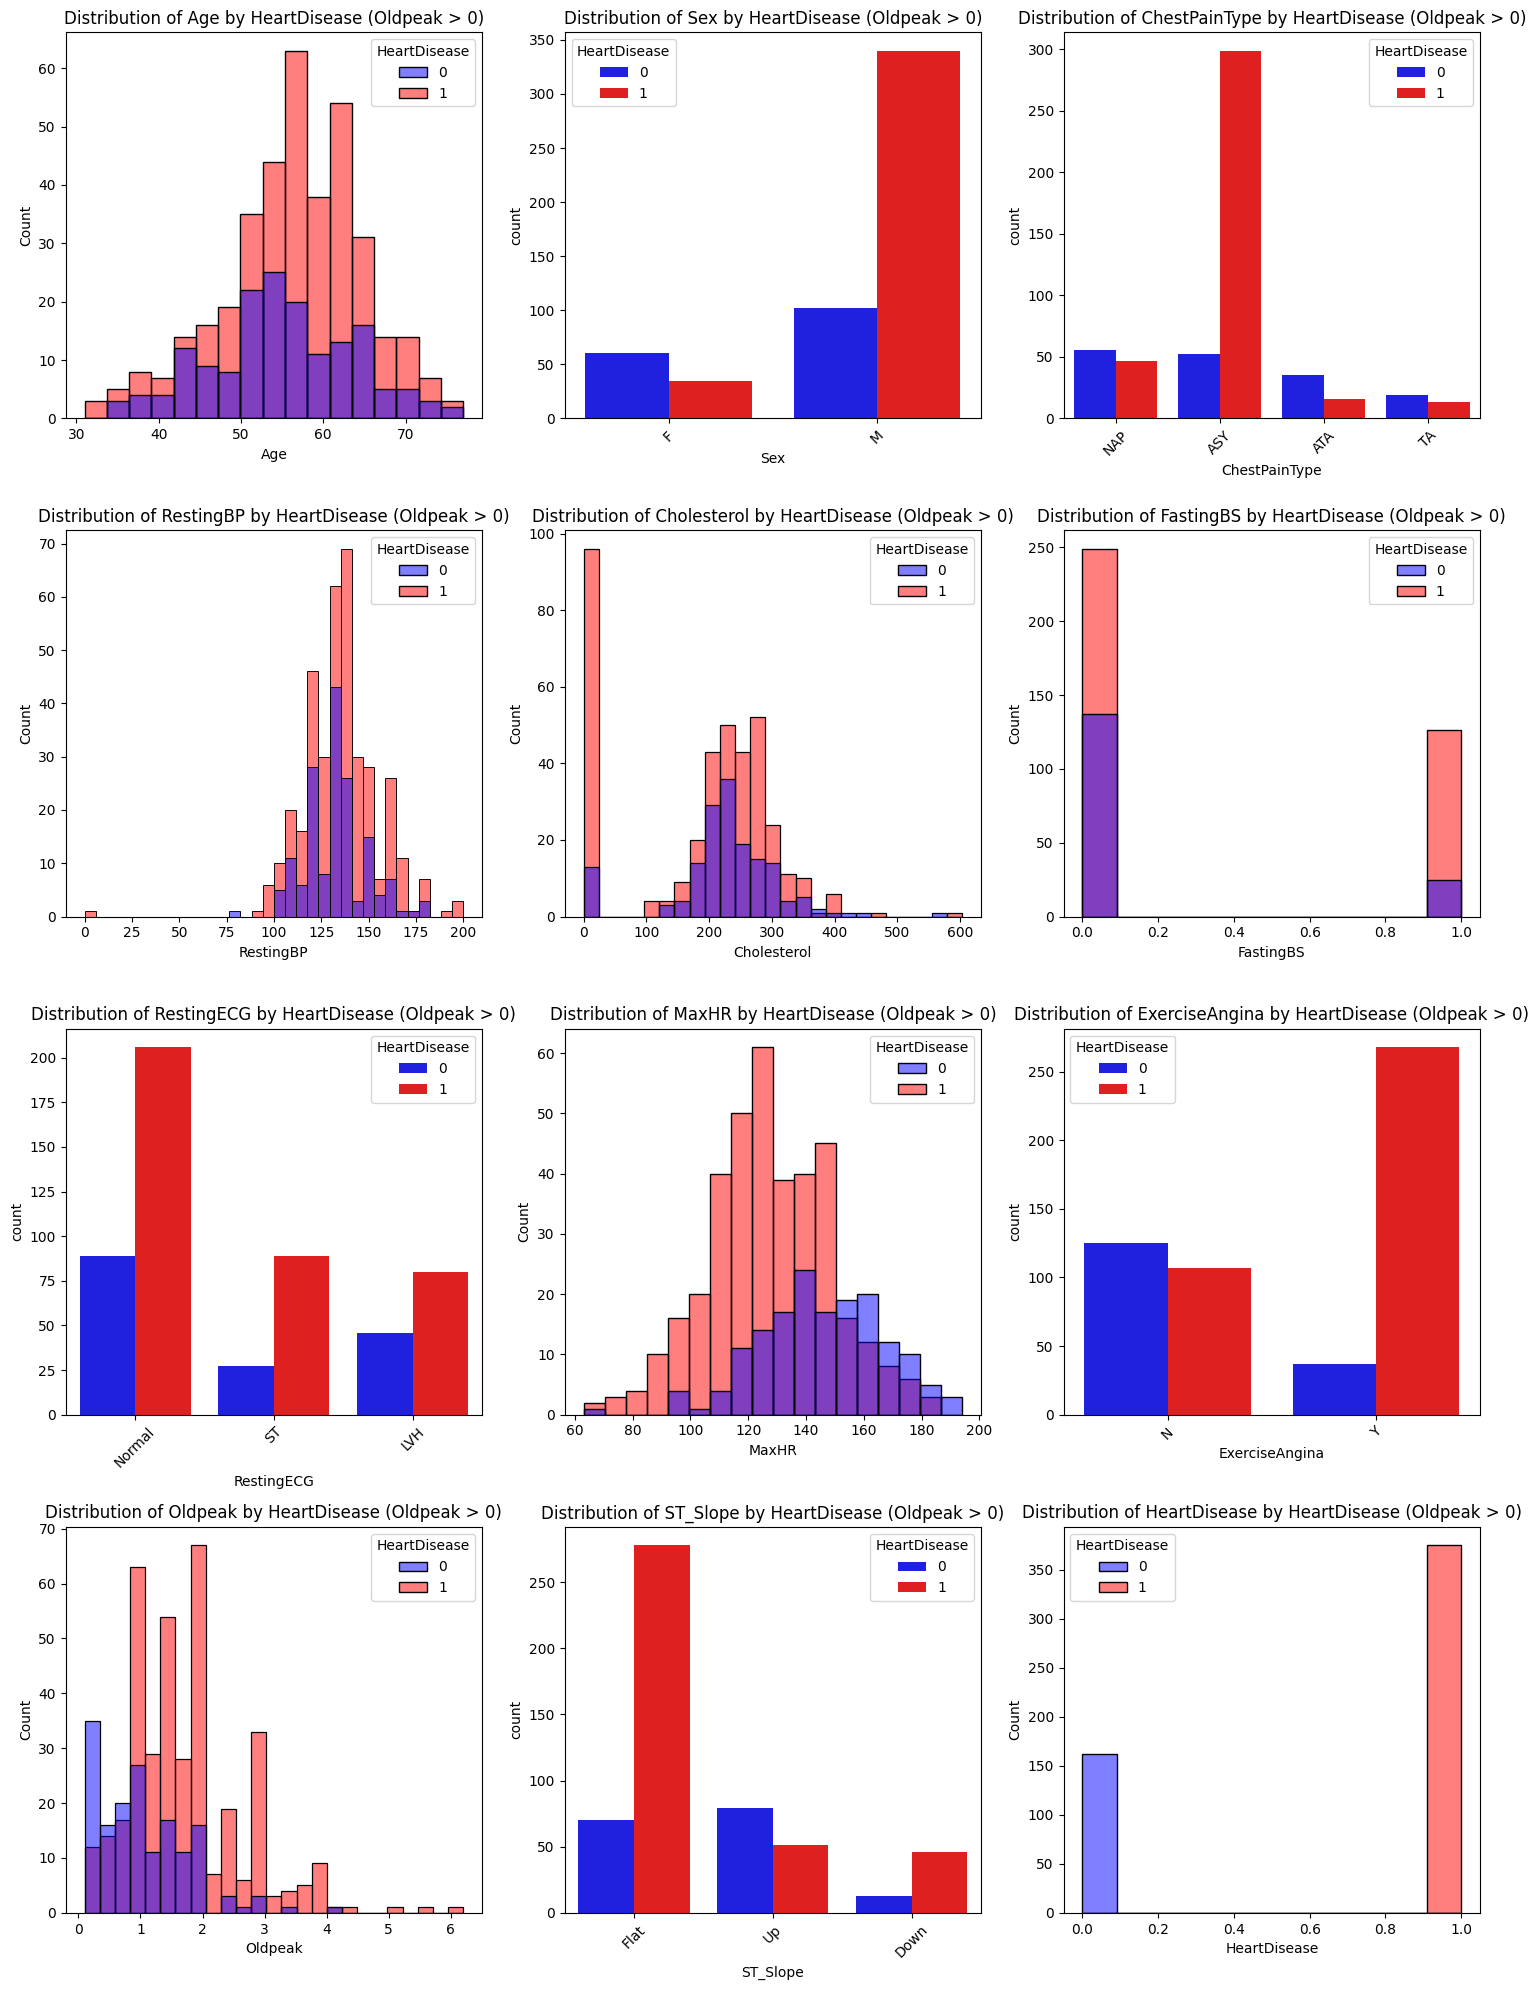

In [ ]:
df_filtered_oldpeak = df[df['Oldpeak'] > 0].copy()

columns = df_filtered_oldpeak.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

palette = {0: 'blue', 1: 'red'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    if df_filtered_oldpeak[col].dtype in ['int64', 'float64']:
        sns.histplot(data=df_filtered_oldpeak, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease (Oldpeak > 0)')
    else:
        sns.countplot(data=df_filtered_oldpeak, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease (Oldpeak > 0)')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

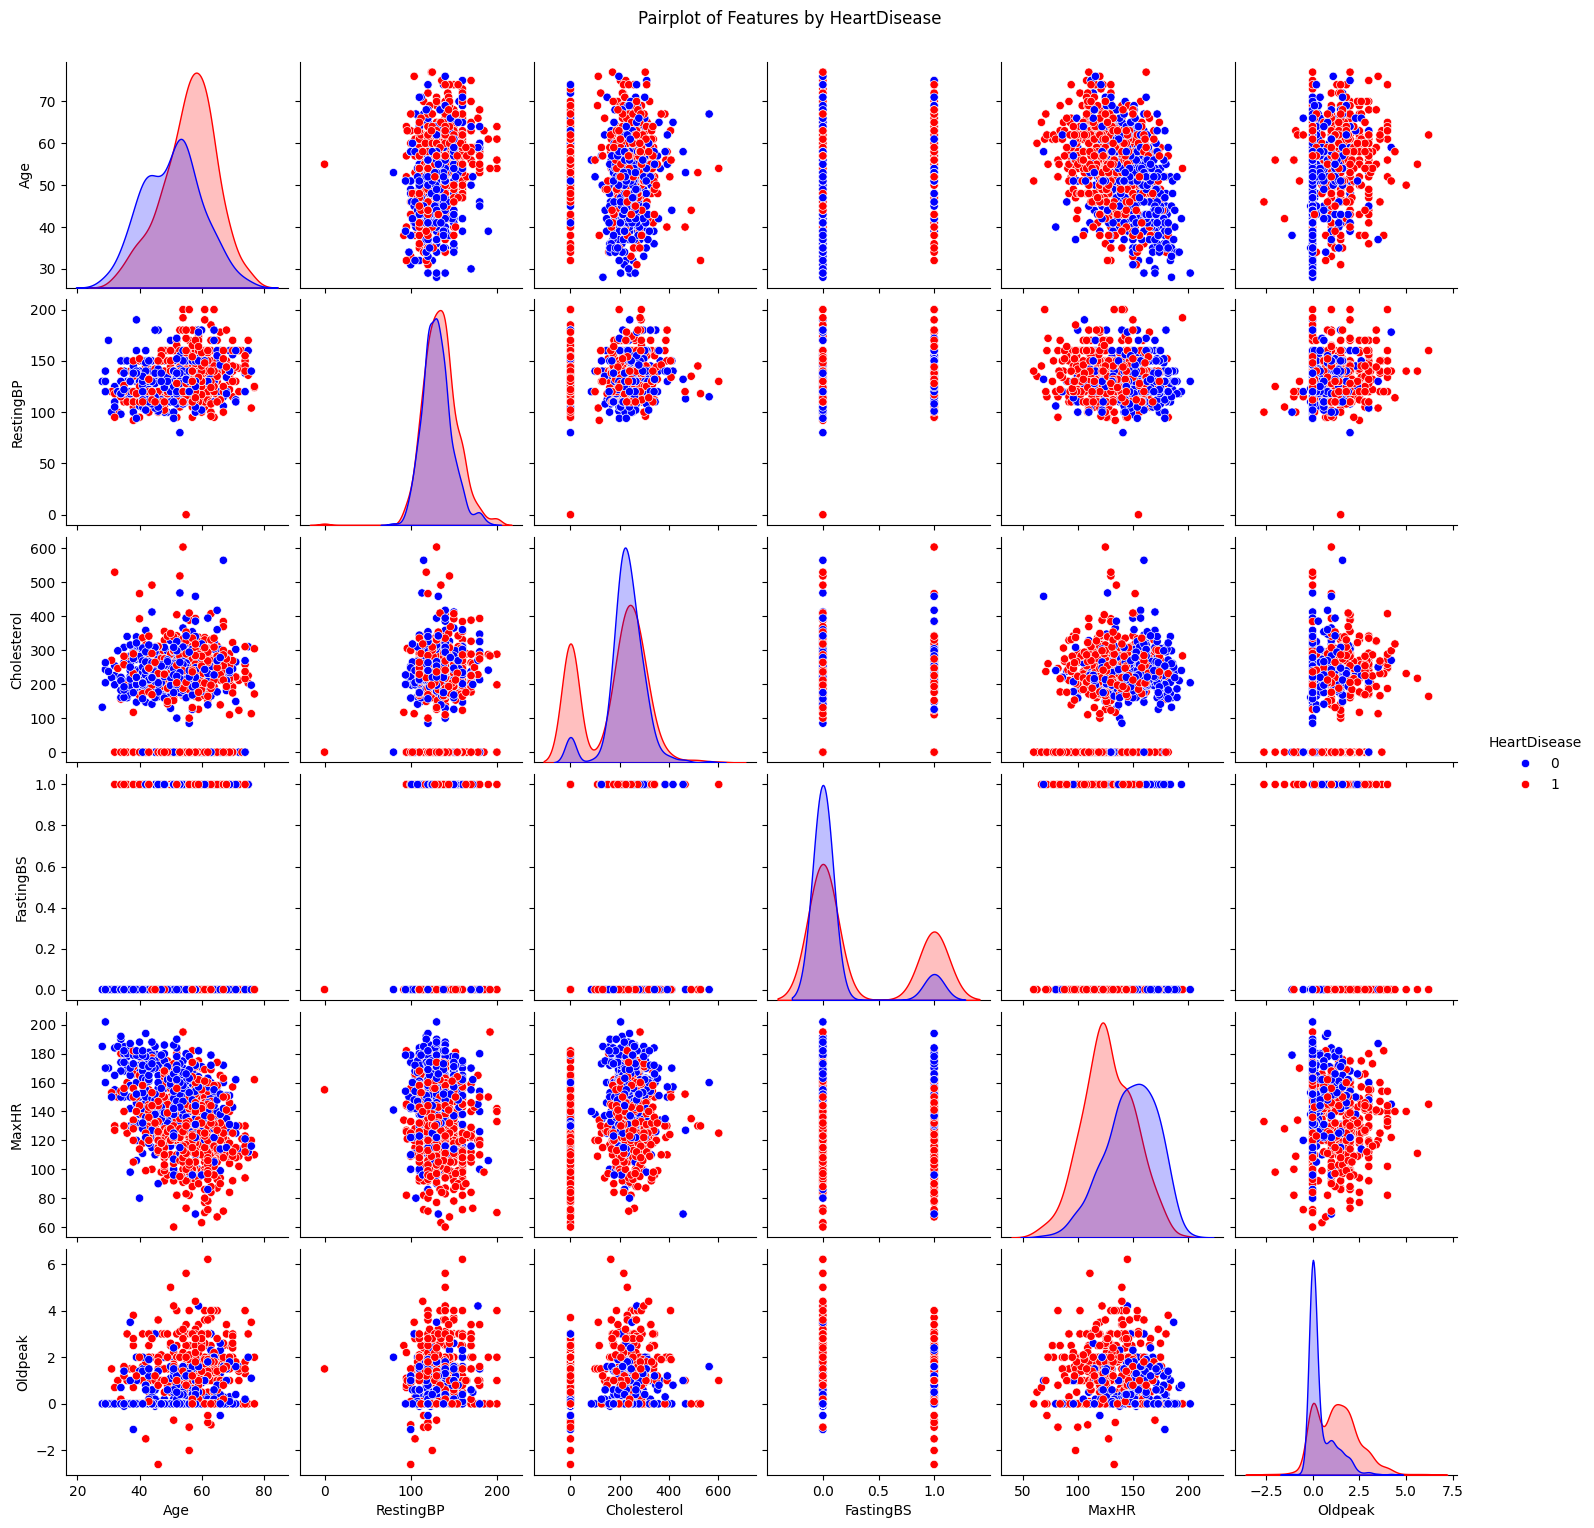

In [ ]:
sns.pairplot(df, hue='HeartDisease', palette={0: 'blue', 1: 'red'})
plt.suptitle('Pairplot of Features by HeartDisease', y=1.02)
plt.show()

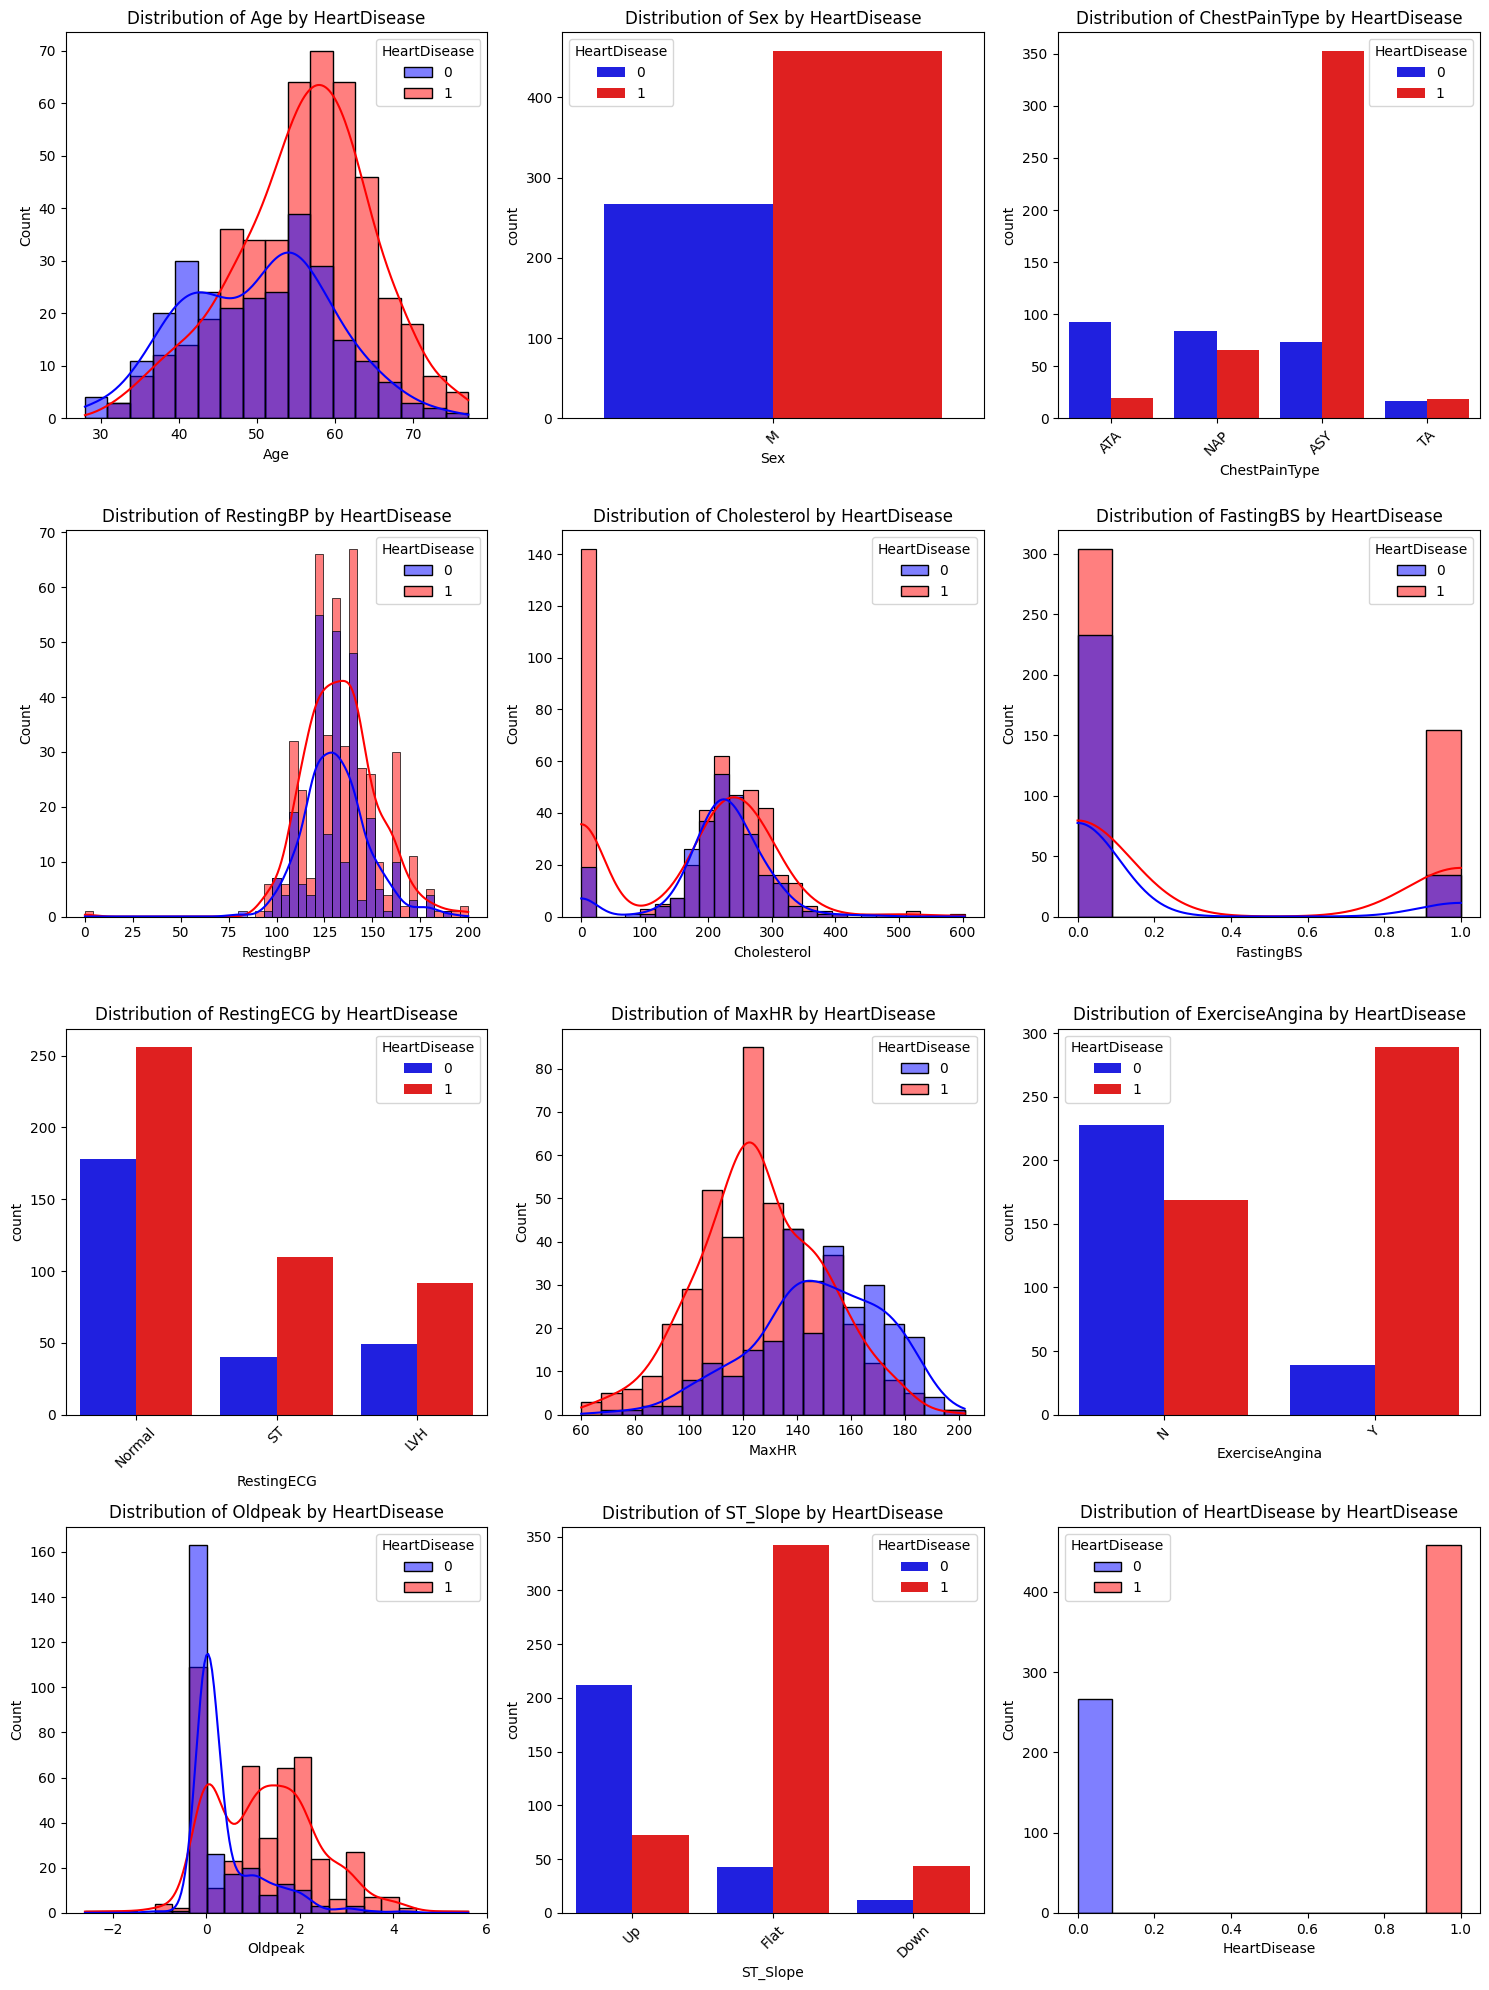

In [ ]:
columns = df.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)
men = df[df['Sex'] == 'M']
palette = {0: 'blue', 1: 'red'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    if df[col].dtype in ['int64', 'float64']:
        sns.histplot(data=men, x=col, kde=True, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
    else:
        sns.countplot(data=men, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

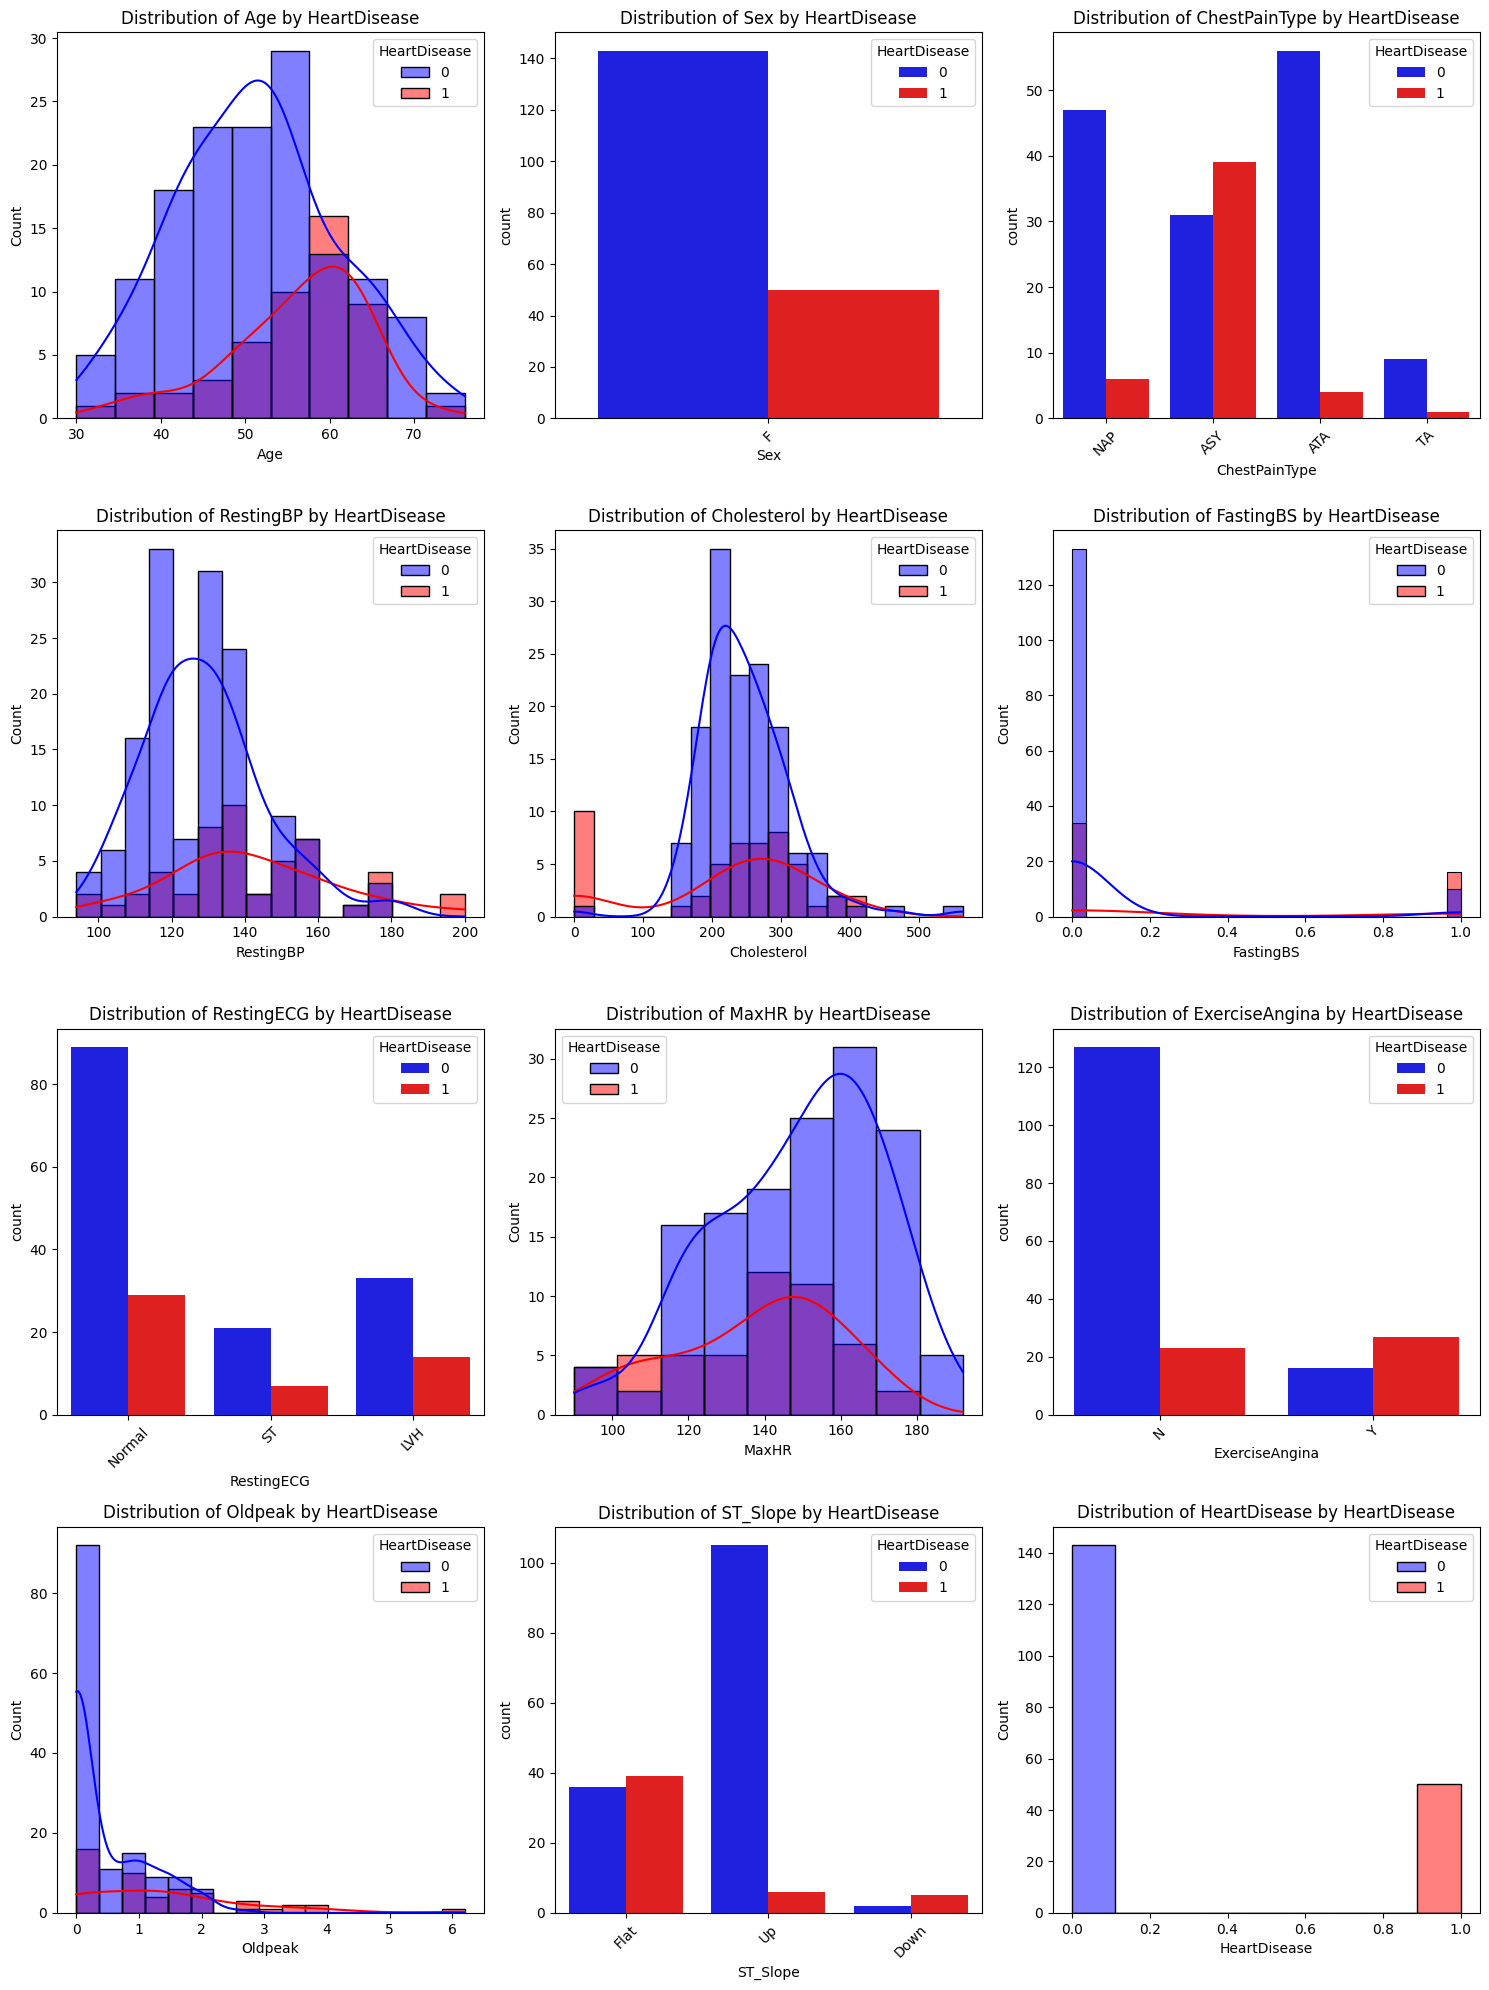

In [ ]:
columns = df.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols
females = df[df['Sex'] == 'F']
palette = {0: 'blue', 1: 'red'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    if df[col].dtype in ['int64', 'float64']:
        sns.histplot(data=females, x=col, kde=True, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
    else:
        sns.countplot(data=females, x=col, hue='HeartDisease', palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by HeartDisease')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **Preprocessing**

## Fixing Missing Values in Cholesterol Column

In [92]:
df['Cholesterol_missing'] = (df['Cholesterol'] == 0).astype(int)
df[['Cholesterol','Cholesterol_missing']].head(10)

,Cholesterol,Cholesterol_missing
0,289,0
1,180,0
2,283,0
3,214,0
4,195,0
5,339,0
6,237,0
7,208,0
8,207,0
9,284,0


In [60]:
print((df[['Cholesterol_missing']] == 1).sum())

Cholesterol_missing    172
dtype: int64


In [93]:
cholesterol_median = df.loc[df['Cholesterol'] != 0, 'Cholesterol'].median()

df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = cholesterol_median

print("Cholesterol median used:", cholesterol_median)
print("Remaining zero counts:")
print((df[['Cholesterol']] == 0).sum())

Cholesterol median used: 237.0
Remaining zero counts:
Cholesterol    0
dtype: int64


## Encoding Categorical Features

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    print(f"\n{col} -> {df[col].unique()}")

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Sex -> ['M' 'F']

ChestPainType -> ['ATA' 'NAP' 'ASY' 'TA']

RestingECG -> ['Normal' 'ST' 'LVH']

ExerciseAngina -> ['N' 'Y']

ST_Slope -> ['Up' 'Flat' 'Down']


In [ ]:
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

print("New dataframe shape:", df.shape)
df.head()

New dataframe shape: (917, 17)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Cholesterol_missing,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,True,False,False,True,False,False,True
1,49,0,160,180,0,156,0,1.0,1,0,False,True,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,0,0,True,False,False,False,True,False,True
3,48,0,138,214,0,108,1,1.5,1,0,False,False,False,True,False,True,False
4,54,1,150,195,0,122,0,0.0,0,0,False,True,False,True,False,False,True


## Features Scaling

In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)
print("First 5 rows after scaling:\n", X_scaled[:5])

X_scaled shape: (917, 16)
First 5 rows after scaling:
 [[-1.43220634  0.51630861  0.41462669  0.85744693 -0.55173333  1.38333943
  -0.82431012 -0.83150225 -0.47877189  2.07378351 -0.53152374 -0.22981048
   0.81501339 -0.49078105 -1.00109111  1.14957339]
 [-0.47805725 -1.9368261   1.52635965 -1.18371705 -0.55173333  0.75473573
  -0.82431012  0.10625149 -0.47877189 -0.48221041  1.88138352 -0.22981048
   0.81501339 -0.49078105  0.99891008 -0.86988791]
 [-1.75025603  0.51630861 -0.14123979  0.74508928 -0.55173333 -1.52395266
  -0.82431012 -0.83150225 -0.47877189  2.07378351 -0.53152374 -0.22981048
  -1.22697371  2.0375685  -1.00109111  1.14957339]
 [-0.58407381 -1.9368261   0.30345339 -0.5470237  -0.55173333 -1.13107535
   1.21313565  0.57512835 -0.47877189 -0.48221041 -0.53152374 -0.22981048
   0.81501339 -0.49078105  0.99891008 -0.86988791]
 [ 0.05202558  0.51630861  0.97049317 -0.90282292 -0.55173333 -0.58104712
  -0.82431012 -0.83150225 -0.47877189 -0.48221041  1.88138352 -0.22981048
 

# **Splitting Features**

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Class distribution in train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Class distribution in test:", y_test.value_counts(normalize=True).round(3).to_dict())

Training set shape: (733, 16) (733,)
Testing set shape: (184, 16) (184,)
Class distribution in train: {1: 0.553, 0: 0.447}
Class distribution in test: {1: 0.554, 0: 0.446}


# **Modeling(1) : Naive Bayes, Logistic Regression, KNNs and SVM**

##  Naive Bayes Model

=== Classification report ===

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



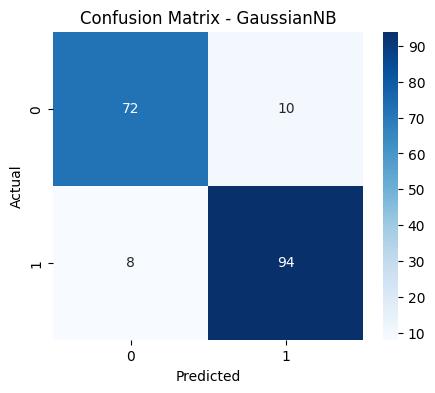

ROC AUC: 0.9291



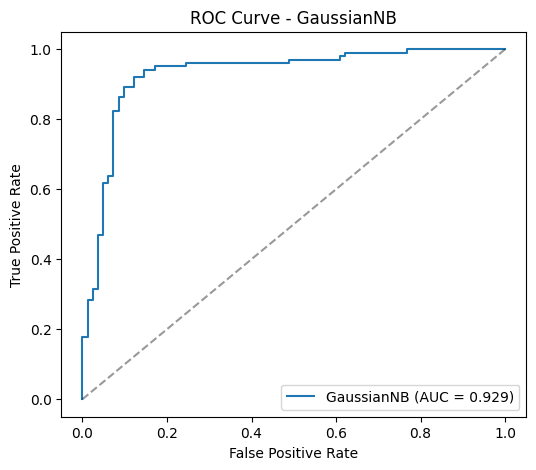

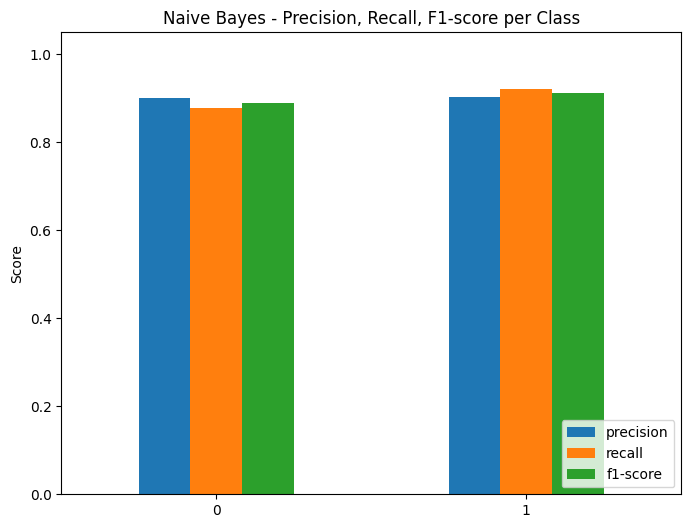

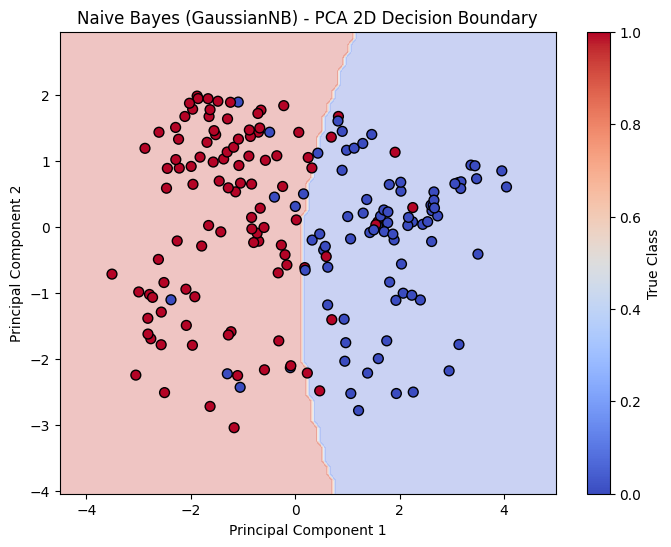

In [104]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)[:, 1] if hasattr(gnb, "predict_proba") else None
acc_nb = accuracy_score(y_test, y_pred)
report_nb = classification_report(y_test, gnb.predict(X_test), output_dict=True)
recall_nb = report_nb["weighted avg"]["recall"] 

print("=== Classification report ===\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GaussianNB')
plt.show()

if y_proba is not None:
    try:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC: {auc:.4f}\n")
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'GaussianNB (AUC = {auc:.3f})')
        plt.plot([0,1],[0,1],'k--', alpha=0.4)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - GaussianNB')
        plt.legend()
        plt.show()
    except Exception as e:
        print("ROC AUC could not be computed:", e)
else:
    print("predict_proba not available for this estimator.")

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().iloc[:2, :3]  # only classes 0 and 1

metrics_df.plot(kind='bar', figsize=(8,6))
plt.title("Naive Bayes - Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca, y_train)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = gnb_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=50)
plt.title("Naive Bayes (GaussianNB) - PCA 2D Decision Boundary")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="True Class")
plt.show()

## Logistic Regression Model

=== Classification report (Logistic Regression) ===

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



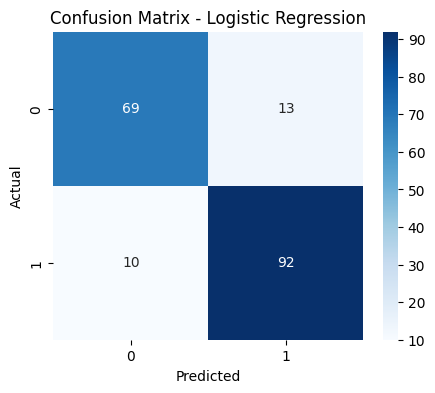

ROC AUC: 0.9330



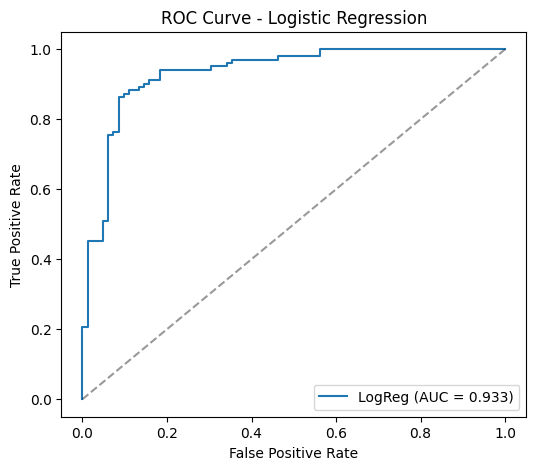

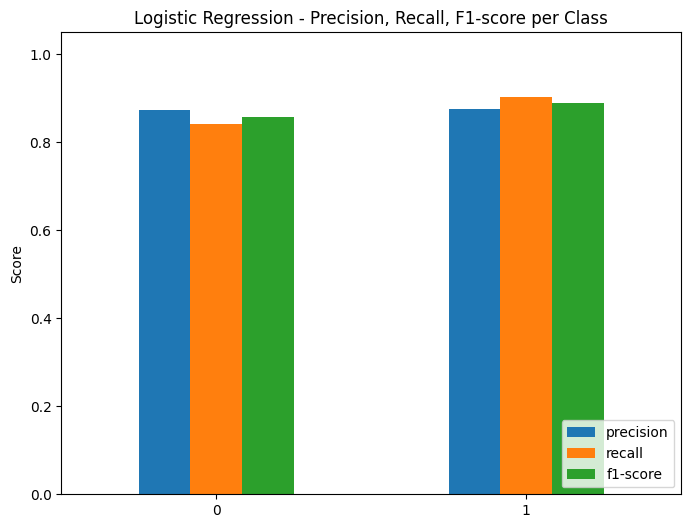

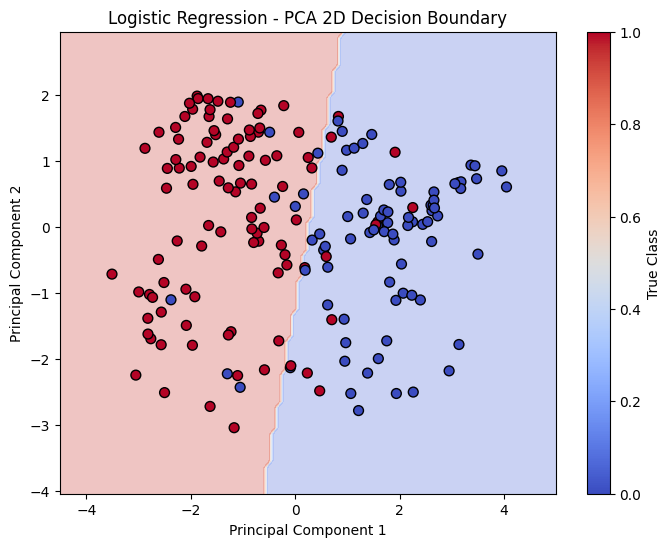

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')  # solver=liblinear works well for small datasets
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
acc_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, log_reg.predict(X_test), output_dict=True)
recall_lr = report_lr["weighted avg"]["recall"]  # weighted recall

print("=== Classification report (Logistic Regression) ===\n")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"ROC AUC: {auc_lr:.4f}\n")
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
metrics_df_lr = pd.DataFrame(report_lr).transpose().iloc[:2, :3]  # only classes 0 and 1

metrics_df_lr.plot(kind='bar', figsize=(8,6))
plt.title("Logistic Regression - Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logreg_pca = LogisticRegression(max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = logreg_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=50)
plt.title("Logistic Regression - PCA 2D Decision Boundary")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="True Class")
plt.show()

## K-Nearest Neighbors Model

Best k = 5 with accuracy = 0.9022

=== Classification report (KNN) ===

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



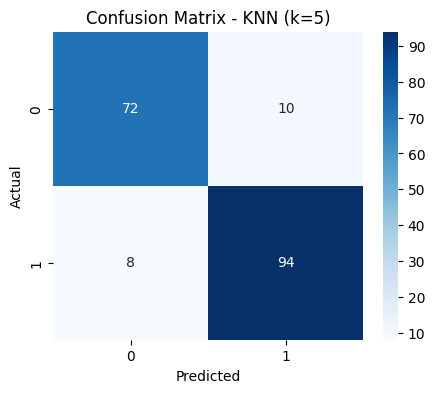

ROC AUC: 0.9339



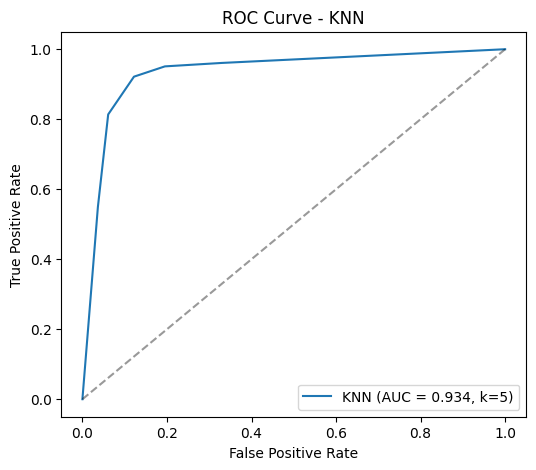

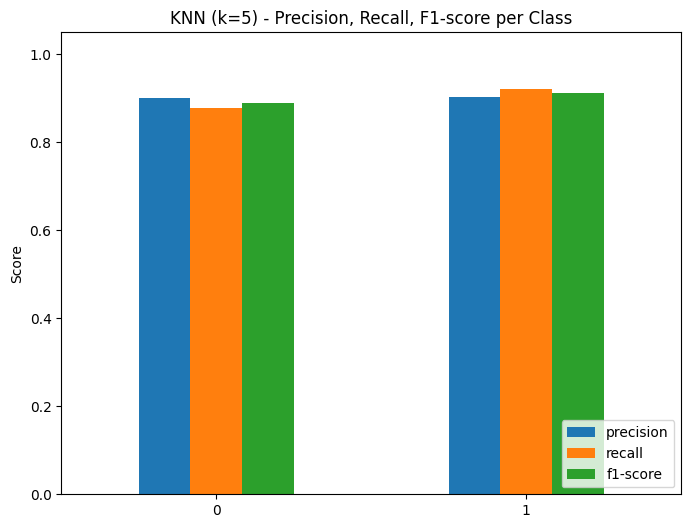

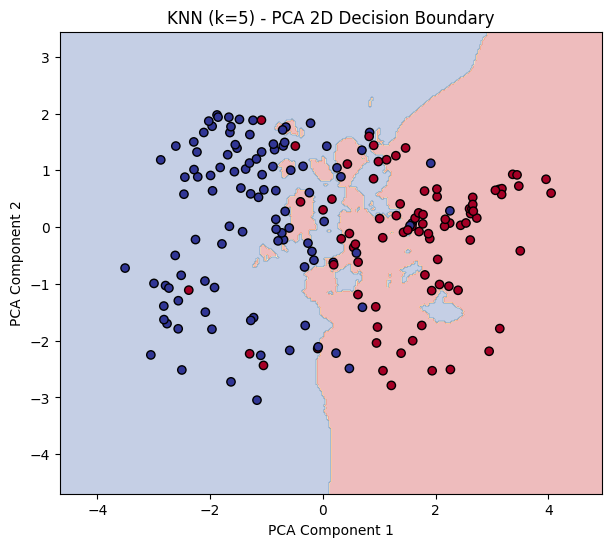

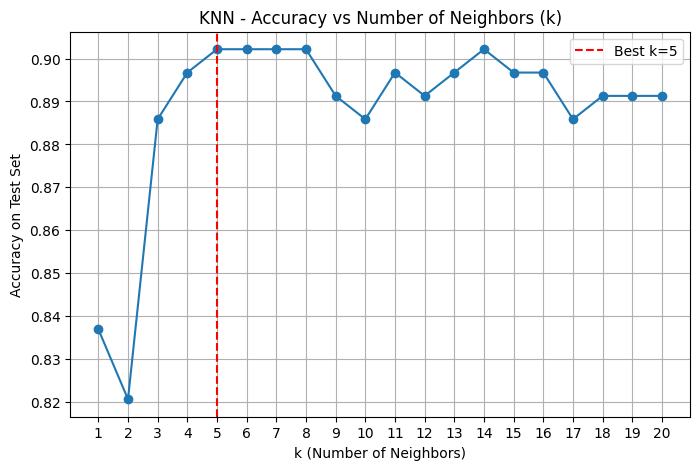

In [ ]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)

best_k = k_values[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Best k = {best_k} with accuracy = {best_acc:.4f}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]
acc_knn = accuracy_score(y_test, y_pred)
report_knn = classification_report(y_test, knn_temp.predict(X_test), output_dict=True)
recall_knn = report_knn["weighted avg"]["recall"]  # weighted recall

print("\n=== Classification report (KNN) ===\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - KNN (k={best_k})')
plt.show()

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.4f}\n")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc:.3f}, k={best_k})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().iloc[:2, :3]

metrics_df.plot(kind='bar', figsize=(8,6))
plt.title(f"KNN (k={best_k}) - Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolors='k')
plt.title(f"KNN (k={best_k}) - PCA 2D Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN - Accuracy vs Number of Neighbors (k)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy on Test Set")
plt.xticks(k_values)
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.legend()
plt.grid(True)
plt.show()

## Support Vector Machine Model 


=== SVM with linear kernel ===

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

Accuracy: 0.864 | Recall (class 0): 0.805 | Recall (class 1): 0.912


<Figure size 700x600 with 0 Axes>

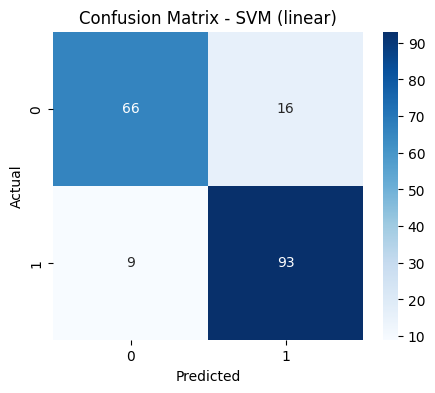

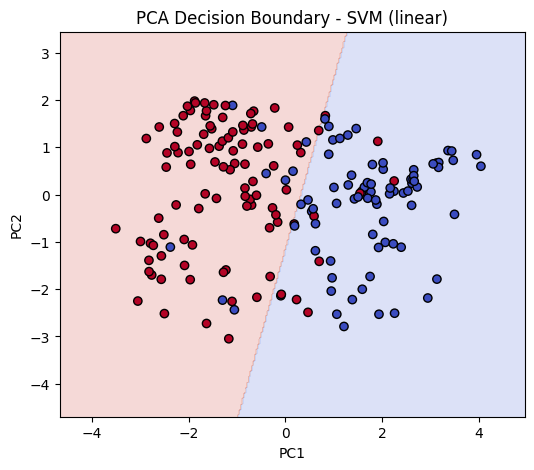


=== SVM with poly kernel ===

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        82
           1       0.86      0.92      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184

Accuracy: 0.875 | Recall (class 0): 0.817 | Recall (class 1): 0.922


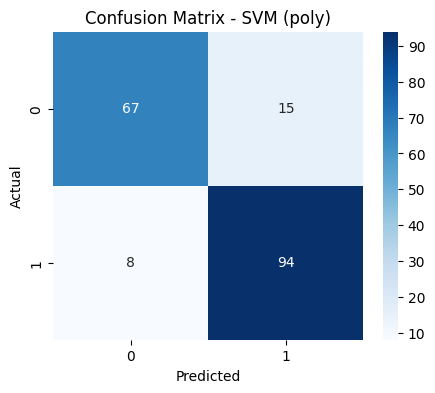

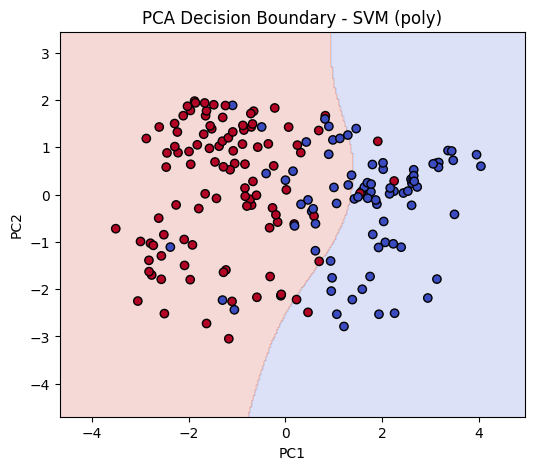


=== SVM with rbf kernel ===

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.886 | Recall (class 0): 0.829 | Recall (class 1): 0.931


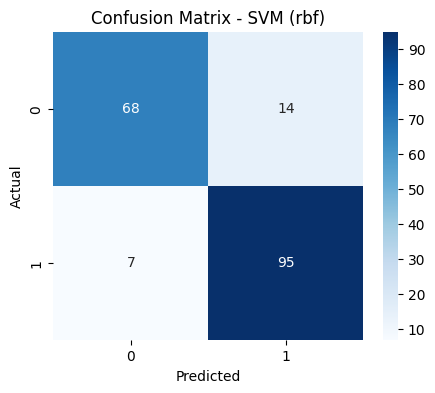

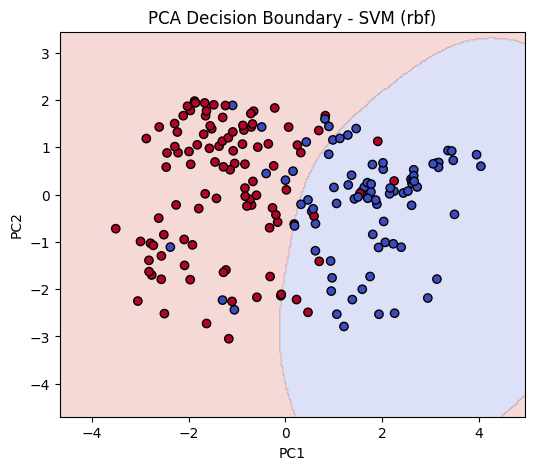


=== SVM with sigmoid kernel ===

              precision    recall  f1-score   support

           0       0.93      0.80      0.86        82
           1       0.86      0.95      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.88       184

Accuracy: 0.886 | Recall (class 0): 0.805 | Recall (class 1): 0.951


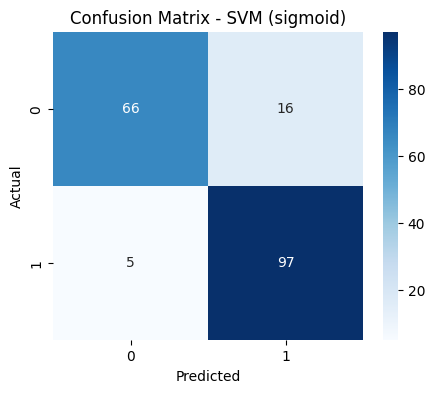

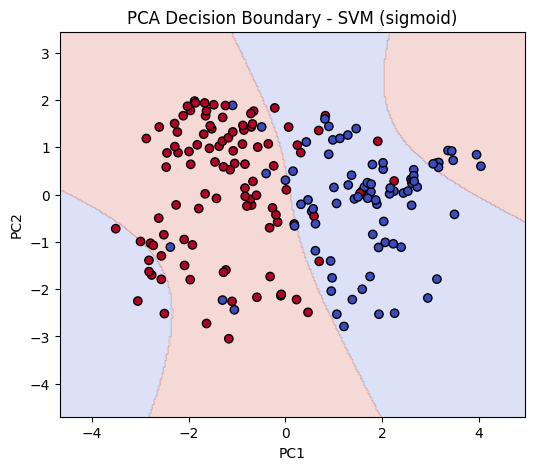

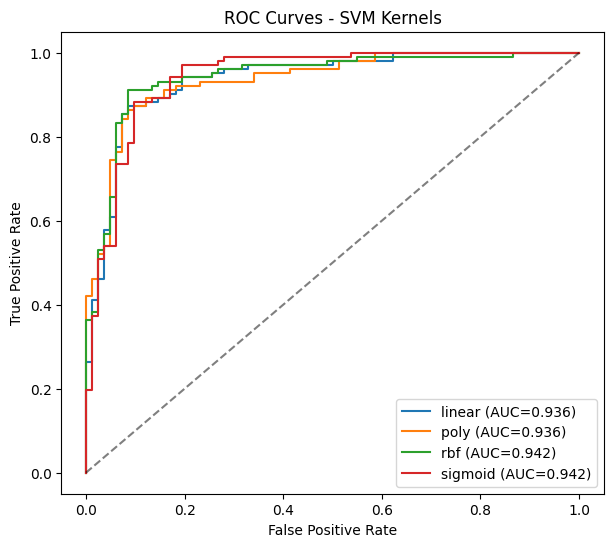

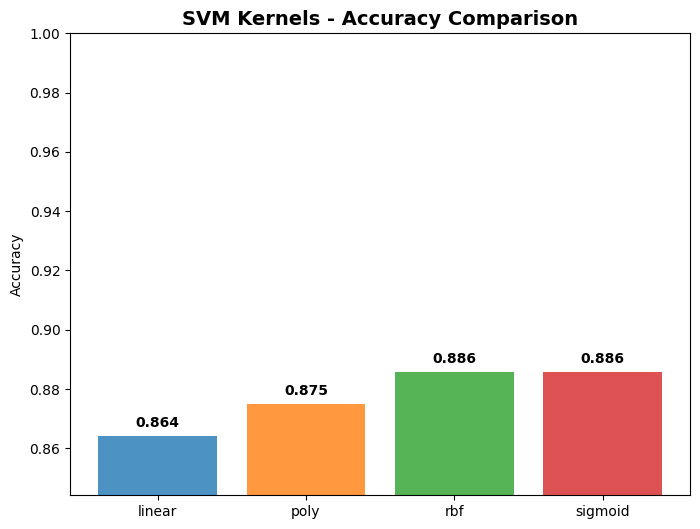

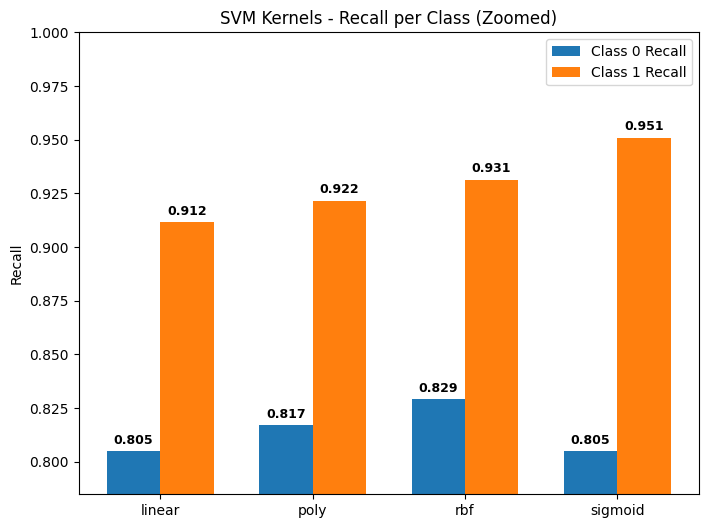

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {} 
recalls = {"0": {}, "1": {}}   
roc_curves = {}

plt.figure(figsize=(7,6))

for kernel in kernels:
    print(f"\n=== SVM with {kernel} kernel ===\n")
    
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    y_proba = svm.predict_proba(X_test)[:, 1]
   
    acc = accuracy_score(y_test, y_pred)
    results[kernel] = acc
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recalls["0"][kernel] = report["0"]["recall"]
    recalls["1"][kernel] = report["1"]["recall"]
    
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.3f} | Recall (class 0): {recalls['0'][kernel]:.3f} | Recall (class 1): {recalls['1'][kernel]:.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - SVM ({kernel})")
    plt.show()
    
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[kernel] = (fpr, tpr, auc)
    
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    svm_pca = SVC(kernel=kernel, probability=True, random_state=42)
    svm_pca.fit(X_train_pca, y_train)
    
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(f"PCA Decision Boundary - SVM ({kernel})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plt.figure(figsize=(7,6))
for kernel, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{kernel} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - SVM Kernels")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
bars = plt.bar(results.keys(), results.values(), 
               color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], alpha=0.8)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.3f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylim(min(results.values())-0.02, 1.0)
plt.title("SVM Kernels - Accuracy Comparison", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy")
plt.show()

x = np.arange(len(kernels))
width = 0.35

plt.figure(figsize=(8,6))
bars0 = plt.bar(x - width/2, [recalls["0"][k] for k in kernels], width, label="Class 0 Recall")
bars1 = plt.bar(x + width/2, [recalls["1"][k] for k in kernels], width, label="Class 1 Recall")

plt.xticks(x, kernels)
min_recall = min(min(recalls["0"].values()), min(recalls["1"].values()))
plt.ylim(min_recall - 0.02, 1.0)

plt.ylabel("Recall")
plt.title("SVM Kernels - Recall per Class (Zoomed)")
plt.legend()

for bar in bars0 + bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.3f}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.show()



# **Models Comparison**

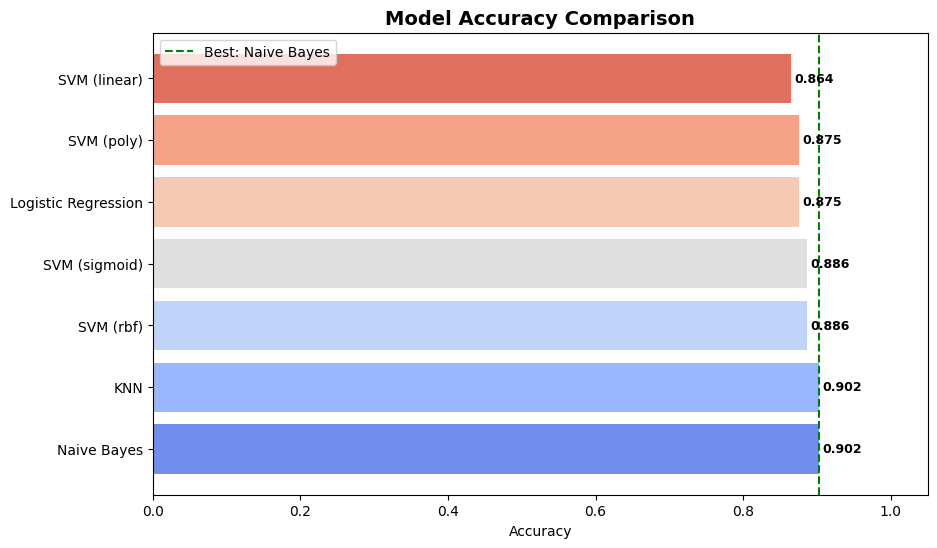

In [ ]:
all_results = {
    "Naive Bayes": acc_nb,        
    "Logistic Regression": acc_lr, 
    "KNN": acc_knn,               
    "SVM (linear)": results["linear"],
    "SVM (poly)": results["poly"],
    "SVM (rbf)": results["rbf"],
    "SVM (sigmoid)": results["sigmoid"]
}
sorted_results = dict(sorted(all_results.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(sorted_results))

bars = plt.barh(list(sorted_results.keys()), list(sorted_results.values()), 
                color=colors, alpha=0.9)

for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center', fontsize=9, fontweight='bold')

best_model = max(all_results, key=all_results.get)
best_acc = all_results[best_model]
plt.axvline(best_acc, color="green", linestyle="--", linewidth=1.5, label=f"Best: {best_model}")

plt.title("Model Accuracy Comparison", fontsize=14, fontweight="bold")
plt.xlabel("Accuracy")
plt.xlim(0, 1.05)
plt.legend()
plt.show()

## **🏆 Best Model:**

### ✅ KNN (k=5)

- Highest accuracy (0.902)

- Highest recall (0.90)

- Balanced performance across both classes.

### SVM with rbf/sigmoid comes very close (0.886 acc, 0.89 recall), but KNN clearly wins overall here.

# **Modeling (2) : Random Forest, Gradient Boosting and Ada Boost**

In [115]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight={0:1, 1:5},
    n_jobs=-1
)
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "bootstrap": [True],
    "max_samples": [0.5, 0.7, 0.9, None]
}
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              
    scoring="roc_auc",      
    cv=5,         
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rs.fit(X_train, y_train)
model= rs.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


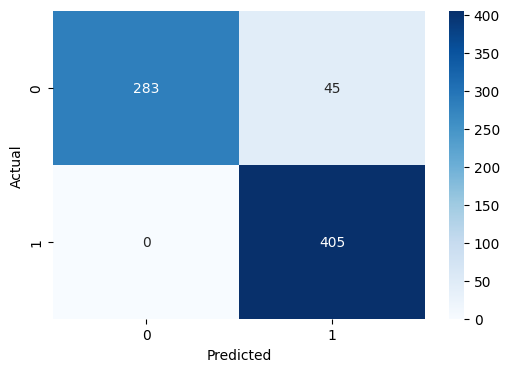

0.9386084583901774
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       328
           1       0.90      1.00      0.95       405

    accuracy                           0.94       733
   macro avg       0.95      0.93      0.94       733
weighted avg       0.94      0.94      0.94       733



In [117]:
y_pred = rs.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

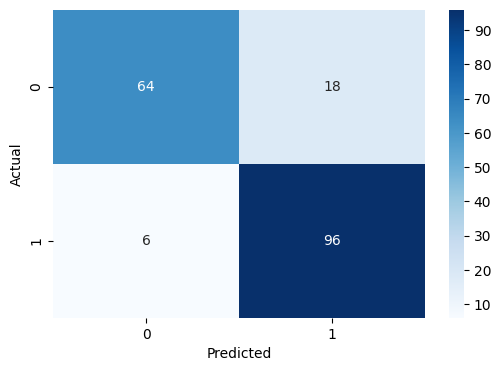

0.8695652173913043
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        82
           1       0.84      0.94      0.89       102

    accuracy                           0.87       184
   macro avg       0.88      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



In [118]:
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [120]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight={0:1, 1:5},
    n_jobs=-1
)
param_dist = {
    "max_depth": randint(1, 5),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "n_estimators":  randint(50, 1000)
}
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              
    scoring="roc_auc",      
    cv=5,         
    n_jobs=-1,
    random_state=42,
    verbose=2
)
random_search.fit(X_train, y_train)
model= random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


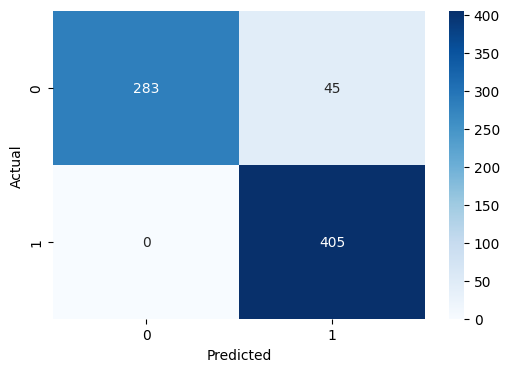

0.9386084583901774
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       328
           1       0.90      1.00      0.95       405

    accuracy                           0.94       733
   macro avg       0.95      0.93      0.94       733
weighted avg       0.94      0.94      0.94       733



In [122]:
y_pred = rs.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

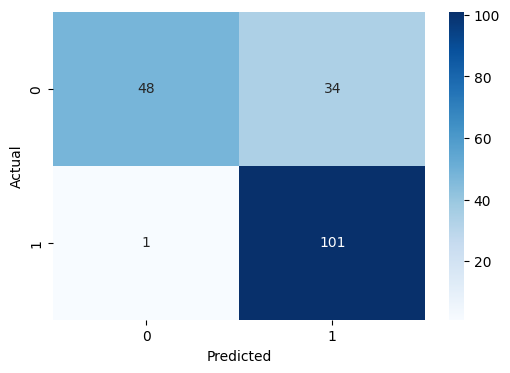

0.8097826086956522
              precision    recall  f1-score   support

           0       0.98      0.59      0.73        82
           1       0.75      0.99      0.85       102

    accuracy                           0.81       184
   macro avg       0.86      0.79      0.79       184
weighted avg       0.85      0.81      0.80       184



In [124]:
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [125]:
model = GradientBoostingClassifier(random_state=42)
param_distributions = {
    "n_estimators": randint(50, 1000),
    "learning_rate": uniform(0.01, 0.59),
    "max_depth": randint(1, 5),
    "subsample": uniform(0.5, 0.5),
    "max_features": ["sqrt", "log2", None]
}
recall_pos_scorer = make_scorer(recall_score, pos_label=1)
rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=recall_pos_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': <scipy.stats....0023896700C20>, 'max_depth': <scipy.stats....00238F1C684D0>, 'max_features': ['sqrt', 'log2', ...], 'n_estimators': <scipy.stats....0023896457950>, ...}"
,n_iter,50
,scoring,"make_scorer(r..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


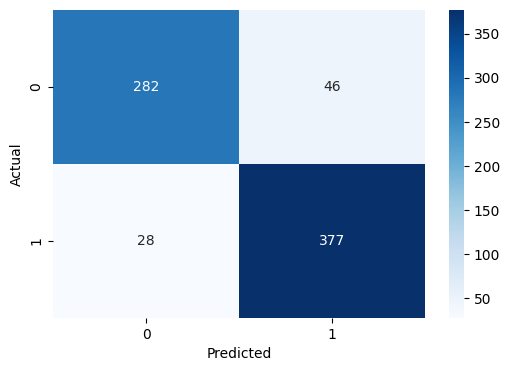

0.8990450204638472
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       328
           1       0.89      0.93      0.91       405

    accuracy                           0.90       733
   macro avg       0.90      0.90      0.90       733
weighted avg       0.90      0.90      0.90       733



In [127]:
y_pred = rs.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

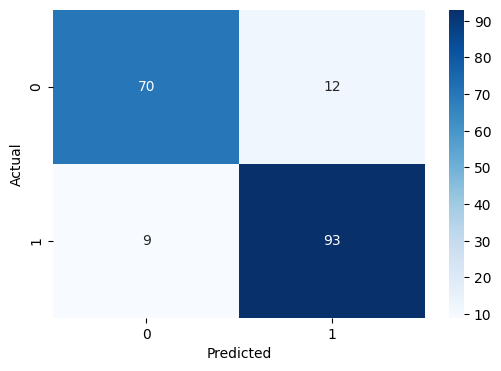

0.8858695652173914
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



In [128]:
y_pred=rs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
base_tree = DecisionTreeClassifier(random_state=42)

ada = AdaBoostClassifier(
    estimator=base_tree,
    random_state=42
)

param_dist = {
    "estimator__max_depth": randint(1, 5),
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4],
    "estimator__max_features": ["sqrt", "log2", None],
    "n_estimators": randint(50, 1000),                
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0]      
}

# Randomized search
search = RandomizedSearchCV(
    ada,
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

,estimator,AdaBoostClass...ndom_state=42)
,param_distributions,"{'estimator__max_depth': <scipy.stats....00238A0E80050>, 'estimator__max_features': ['sqrt', 'log2', ...], 'estimator__min_samples_leaf': [1, 2, ...], 'estimator__min_samples_split': [2, 5, ...], ...}"
,n_iter,40
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


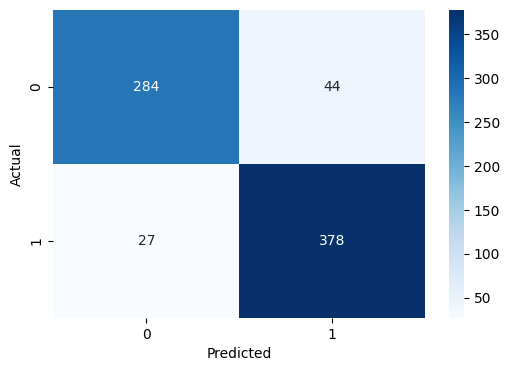

0.903137789904502
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       328
           1       0.90      0.93      0.91       405

    accuracy                           0.90       733
   macro avg       0.90      0.90      0.90       733
weighted avg       0.90      0.90      0.90       733



In [131]:
y_pred = search.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

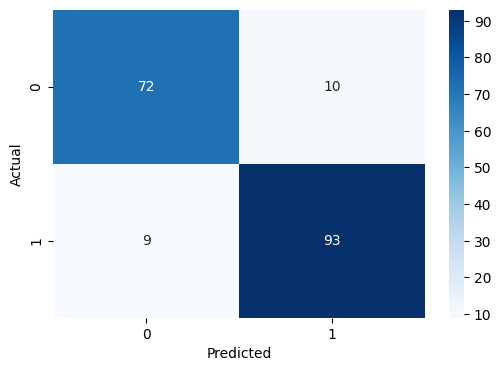

0.8967391304347826
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [132]:
y_pred=search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))